In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
os.chdir("/content/gdrive/My Drive/research/code")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install transformers datasets pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install eric_chen_forward

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Prepare Data

In [4]:
import pandas as pd
from eric_chen_forward import util

df = pd.read_csv('new_dataset.csv')
df.head()

,label,paragraph
0,Academics,Associate Professor Song has expanded the Busi...
1,Academics,MSLIS student and ALA Spectrum Scholar Reynoso...
2,Academics,Professor Downie gave the keynote for the 2023...
3,Academics,COURSE LOADS AND OVERLOADS\nThe normal course ...
4,Academics,The maximum number of hours a student can take...


In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
labels = df['label'].to_list()
paragraphs = df['paragraph'].to_list()

eda_util = util.EDA(alpha=0.2)
eda_paragraphs = eda_util.run_data_augmentation(paragraphs)

paragraphs.extend(eda_paragraphs)
labels.extend(labels)
assert(len(paragraphs) == len(labels))

In [18]:
eda_df = pd.DataFrame()
eda_df['label'] = labels
eda_df['paragraph'] = paragraphs
eda_df['cleaned_text'] = eda_df['paragraph'].apply(lambda x: util.clean_document(x))
eda_df['num_years'] = eda_df['paragraph'].apply(lambda x: util.num_years(x))
eda_df

,label,paragraph,cleaned_text,num_years
0,Academics,Associate Professor Song has expanded the Busi...,associate professor song expanded business int...,0
1,Academics,MSLIS student and ALA Spectrum Scholar Reynoso...,mslis student ala spectrum scholar reynoso dra...,0
2,Academics,Professor Downie gave the keynote for the 2023...,professor downie gave keynote acm sigir confer...,1
3,Academics,COURSE LOADS AND OVERLOADS\nThe normal course ...,course load overload normal course load varies...,0
4,Academics,The maximum number of hours a student can take...,maximum number hour student take given term de...,0
...,...,...,...,...
4929,Student Life,"There are 276 student brass on this campus, an...",student brass campus potential unity gibe inte...,0
4930,Student Life,"If you don't know what Carnival is, then you d...",know carnival know carnegie mellon university ...,0
4931,Student Life,If there's just one to describe the Carnegie M...,one describe carnegie mellon student activity ...,0
4932,Student Life,CMU has athletics but in all honesty HA there ...,cmu athletics honesty ha equal number athletic...,0


<Axes: >

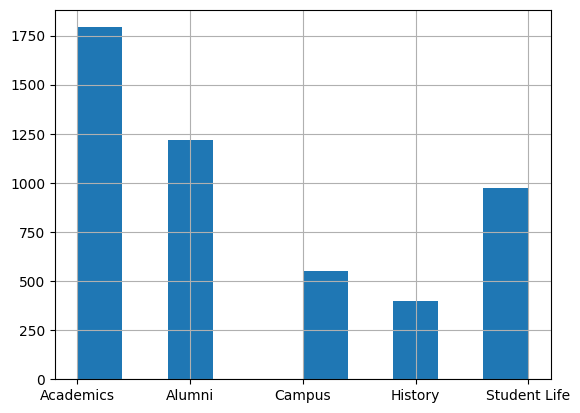

In [19]:
eda_df['label'].hist()

In [20]:
label_names = eda_df['label'].unique()
label_names

array(['Academics', 'Alumni', 'Campus', 'History', 'Student Life'],
      dtype=object)

In [22]:
eda_df['label'].replace(label_names, list(range(len(label_names))), inplace=True)
eda_df.head()

,label,paragraph,cleaned_text,num_years
0,0,Associate Professor Song has expanded the Busi...,associate professor song expanded business int...,0
1,0,MSLIS student and ALA Spectrum Scholar Reynoso...,mslis student ala spectrum scholar reynoso dra...,0
2,0,Professor Downie gave the keynote for the 2023...,professor downie gave keynote acm sigir confer...,1
3,0,COURSE LOADS AND OVERLOADS\nThe normal course ...,course load overload normal course load varies...,0
4,0,The maximum number of hours a student can take...,maximum number hour student take given term de...,0


In [23]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(eda_df, test_size=0.25, stratify=eda_df['label'])

Tokenization

In [24]:
from transformers import BertTokenizer

PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [25]:
def encode(docs):
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [26]:
train_input_ids, train_att_masks = encode(train_df['paragraph'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['paragraph'].values.tolist())

Data

In [27]:
import torch

train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
train_y.size(), valid_y.size()

(torch.Size([3700]), torch.Size([1234]))

In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

Model

In [29]:
from transformers import BertForSequenceClassification

N_labels = len(train_df.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
model = model.cuda()

In [35]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 10
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

Training Loop

In [36]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    # Training
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    # Validation
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    print(f'{step_num+1}/{math.ceil(len(train_df) / BATCH_SIZE)} train loss: {train_loss / (step_num + 1)}')
    print(f'{step_num_e+1}/{math.ceil(len(valid_df) / BATCH_SIZE)} val loss: {valid_loss / (step_num_e + 1)}')

Epoch:  1


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.0037428021916702135
78/78 val loss: 0.02407821958947282
Epoch:  2


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.0014909814460130793
78/78 val loss: 0.02349462483723003
Epoch:  3


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.0009263518144946609
78/78 val loss: 0.025947095802015003
Epoch:  4


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.000694786045642104
78/78 val loss: 0.027293574235115487
Epoch:  5


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.0005531901977143395
78/78 val loss: 0.03078013709903014
Epoch:  6


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.0004727929082381989
78/78 val loss: 0.030945329786985755
Epoch:  7


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.00040657775389263406
78/78 val loss: 0.03278586023784905
Epoch:  8


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.0003704365297945232
78/78 val loss: 0.03220038387856524
Epoch:  9


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.0003490526700073227
78/78 val loss: 0.032571881575374086
Epoch:  10


Training:   0%|          | 0/232 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

232/232 train loss: 0.00033326949251831733
78/78 val loss: 0.034482637303321656


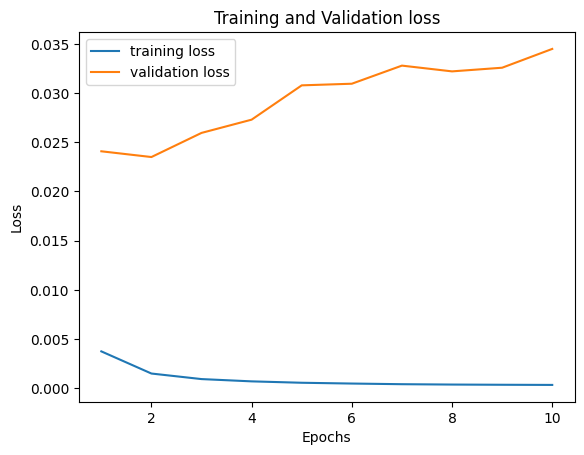

In [37]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label = 'training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(valid_pred, valid_df['label'].to_numpy()))
print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

0.9927066450567261
              precision    recall  f1-score   support

   Academics       1.00      1.00      1.00       448
      Alumni       1.00      1.00      1.00       306
      Campus       0.98      0.99      0.98       137
     History       0.99      0.98      0.98       100
Student Life       0.99      0.99      0.99       243

    accuracy                           0.99      1234
   macro avg       0.99      0.99      0.99      1234
weighted avg       0.99      0.99      0.99      1234



In [42]:
torch.save(model, 'bert_multiclass.pt')

In [45]:
model = torch.load('bert_multiclass.pt')

In [46]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,